In [ ]:
import numpy as np
import pandas as pd
import time 
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/MyDrive/Colab Notebooks/MoA-Prediction/moa_data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_0 = pd.read_csv(data_path + 'train_features.csv',index_col = 0)  
df_0

,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,g-35,g-36,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
sig_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,0.2198,0.2965,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,-0.2102,0.1656,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,-1.1800,0.1256,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,-1.6740,-1.6720,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,-0.7110,-1.4470,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_fffb1ceed,trt_cp,24,D2,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0

In [ ]:
y = pd.read_csv(data_path + 'train_targets_nonscored.csv',index_col = 0 )
y

,abc_transporter_expression_enhancer,abl_inhibitor,ace_inhibitor,acetylcholine_release_enhancer,adenosine_deaminase_inhibitor,adenosine_kinase_inhibitor,adenylyl_cyclase_inhibitor,age_inhibitor,alcohol_dehydrogenase_inhibitor,aldehyde_dehydrogenase_activator,aldose_reductase_inhibitor,alpha_mannosidase_inhibitor,ampk_inhibitor,androgen_biosynthesis_inhibitor,angiotensin_receptor_agonist,antacid,anthelmintic,antihypertensive,antimetabolite,antipruritic,antirheumatic_drug,antiseptic,antispasmodic,antithyroid_agent,antitussive,anxiolytic,ap_inhibitor,apolipoprotein_expression_enhancer,apoptosis_inhibitor,arf_inhibitor,aryl_hydrocarbon_receptor_agonist,aryl_hydrocarbon_receptor_antagonist,aspartic_protease_inhibitor,atherogenesis_inhibitor,atherosclerosis_formation_inhibitor,atp-sensitive_potassium_channel_agonist,atp-sensitive_potassium_channel_inhibitor,atp_channel_activator,atp_channel_blocker,atp_citrase_lyase_inhibitor,...,thromboxane_synthase_inhibitor,thyroid_hormone_inhibitor,thyroid_hormone_stimulant,thyrotropin_releasing_hormone_receptor_agonist,tie_inhibitor,tissue_transglutaminase_inhibitor,topical_anesthetic,topical_sunscreen_agent,trace_amine_associated_receptor_agonist,trace_amine_associated_receptor_antagonist,trail_modulator,transient_receptor_potential_channel_agonist,triacylglycerol_lipase_inhibitor,tricyclic_antidepressant,tryptophan_hydroxylase_inhibitor,tyrosinase_inhibitor,tyrosine_hydroxylase_inhibitor,tyrosine_phosphatase_inhibitor,ubiquitin-conjugating_enzyme_inhibitor,ubiquitin_ligase_inhibitor,urease_inhibitor,uric_acid_diuretic,uricase_inhibitor,uricosuric,urotensin_receptor_agonist,urotensin_receptor_antagonist,vasoconstrictor,vasodilator,vasopressin_receptor_agonist,vasopressin_receptor_antagonist,ve-cadherin_antagonist,vesicular_monoamine_transporter_inhibitor,vitamin_k_antagonist,voltage-gated_calcium_channel_ligand,voltage-gated_potassium_channel_activator,voltage-gated_sodium_channel_blocker,wdr5_mll_interaction_inhibitor,wnt_agonist,xanthine_oxidase_inhibitor,xiap_inhibitor
sig_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
mode_which_part_to_process = 'full'
if mode_which_part_to_process == 'full':
    # consider only gene expression part 
    X = df_0[[c for c in df_0.columns if ('c-' in c) or ('g-' in c)]].values
if mode_which_part_to_process == 'genes':
    # consider only gene expression part 
    X = df_0[[c for c in df_0.columns if 'g-' in c]].values
if mode_which_part_to_process == 'c':
    # consider only gene expression part 
    X = df_0[[c for c in df_0.columns if 'c-' in c]].values

X_original_save = X.copy()
print(X.shape)

y_sum = y.sum(axis = 1)
df_0['y_sum']=y_sum
print(y_sum.shape)
y_sum.value_counts()

(23814, 872)
(23814,)


0    19224
1     4282
2      247
3       36
4       13
7        6
5        6
dtype: int64

PCA inspired by this post: https://www.kaggle.com/alexandervc/moa-data-visualization-via-dimensional-reduct


In [ ]:


from sklearn.decomposition import PCA
import time 
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA()
t0 = time.time()
r = pca.fit_transform(X.copy())
print(time.time()-t0, 'secs passed for PCA')
plt.rc('font', family='serif')
# fig = plt.figure(figsize=(4.5, 2.8))





5.20168137550354 secs passed for PCA


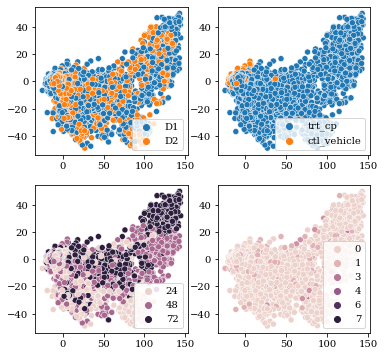

In [ ]:

fig = plt.figure(figsize = (6, 6) )
c = 0
for f in ['cp_dose', 'cp_type','cp_time', 'y_sum']:
    c+=1
    fig.add_subplot(2, 2 , c) 
    sns.scatterplot(x=r[:,0], y=r[:,1] , hue = df_0[f]  )
    # plt.title('Colored by '+f)
    plt.legend(loc='lower right')
plt.savefig(data_path + 'PCA.png', dpi=900)
plt.show()

In [ ]:

fig = plt.figure(figsize = (15,7) )
fig.add_subplot(1, 2, 1) 
plt.plot(pca.singular_values_,'o-')
plt.title('Singular values')
fig.add_subplot(1, 2, 2) 
plt.plot(pca.explained_variance_ratio_,'o-')
plt.title('explained variance')


Correlation study inspired by this: https://www.kaggle.com/isaienkov/mechanisms-of-action-moa-prediction-eda

In [ ]:
train = df_0.copy()
test = y.copy()

df = pd.concat([df_0, y])

In [ ]:
train_columns = train.columns.to_list()

g_list = [
    i for i in train_columns if i.startswith('g-')
]

c_list = [
    i for i in train_columns if i.startswith('c-')
]

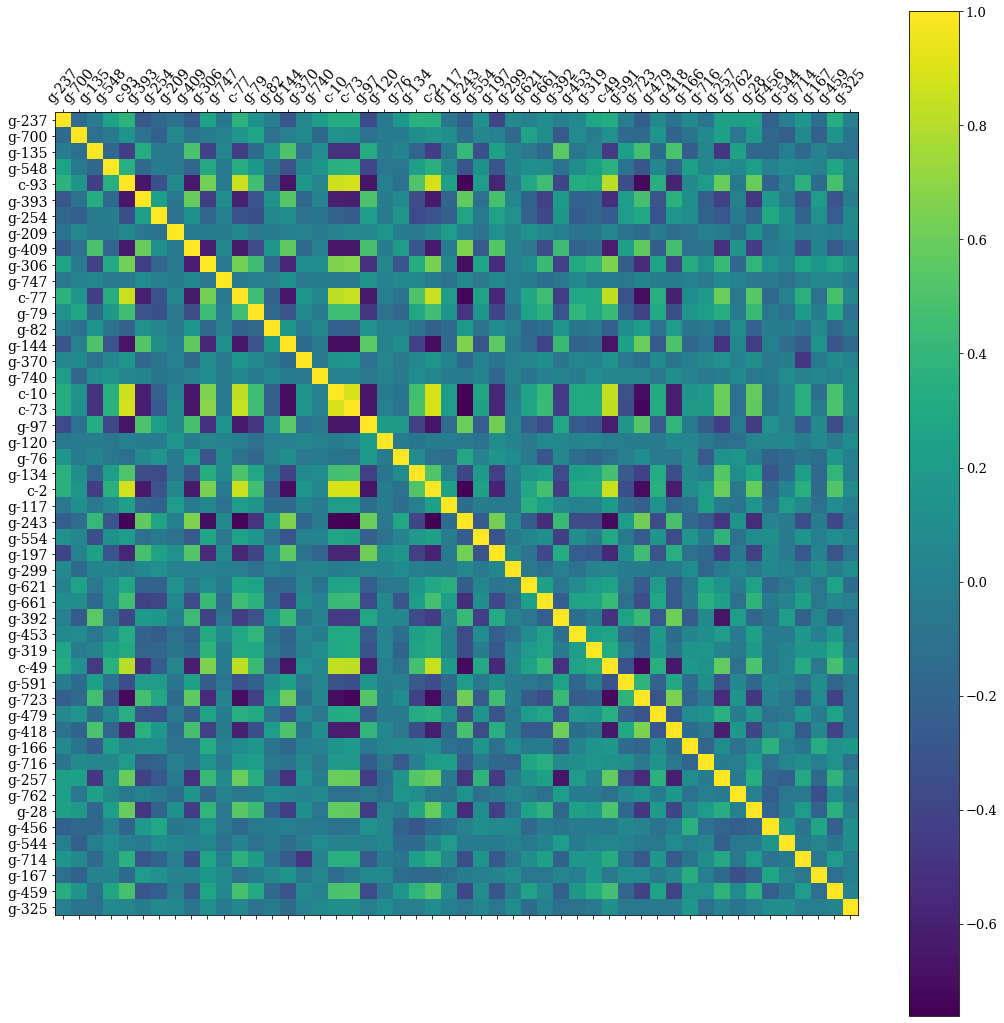

In [ ]:
import random
columns = g_list + c_list
for_correlation = random.sample(columns, 50)
data = df[for_correlation]

f = plt.figure(
    figsize=(18, 18)
)

plt.matshow(
    data.corr(), 
    fignum=f.number
)

plt.xticks(
    range(data.shape[1]), 
    data.columns, 
    fontsize=14, 
    rotation=50
)

plt.yticks(
    range(data.shape[1]), 
    data.columns, 
    fontsize=14
)

cb = plt.colorbar()
cb.ax.tick_params(
    labelsize=13
)

Note: this takes ~2 mins. Pairs with high correlation. `all_columns` has the columns with correlation higher than 0.9

In [ ]:


cols = ['cp_time'] + columns
all_columns = []
for i in range(0, len(cols)):
    for j in range(i+1, len(cols)):
        if abs(train[cols[i]].corr(train[cols[j]])) > 0.9:
            all_columns = all_columns + [cols[i], cols[j]]
all_columns = list(set(all_columns))
print('Number of columns:', len(all_columns))

Number of columns: 35


In [ ]:
all_columns = ['c-94',
 'c-38',
 'c-18',
 'c-13',
 'c-1',
 'c-4',
 'c-6',
 'c-42',
 'c-81',
 'c-17',
 'g-37',
 'c-63',
 'c-40',
 'c-52',
 'c-33',
 'g-50',
 'c-66',
 'c-85',
 'c-60',
 'c-75',
 'c-31',
 'c-2',
 'c-93',
 'c-51',
 'c-73',
 'c-55',
 'c-26',
 'c-11',
 'c-8',
 'c-54',
 'c-82',
 'c-96',
 'c-10',
 'c-90',
 'c-62']

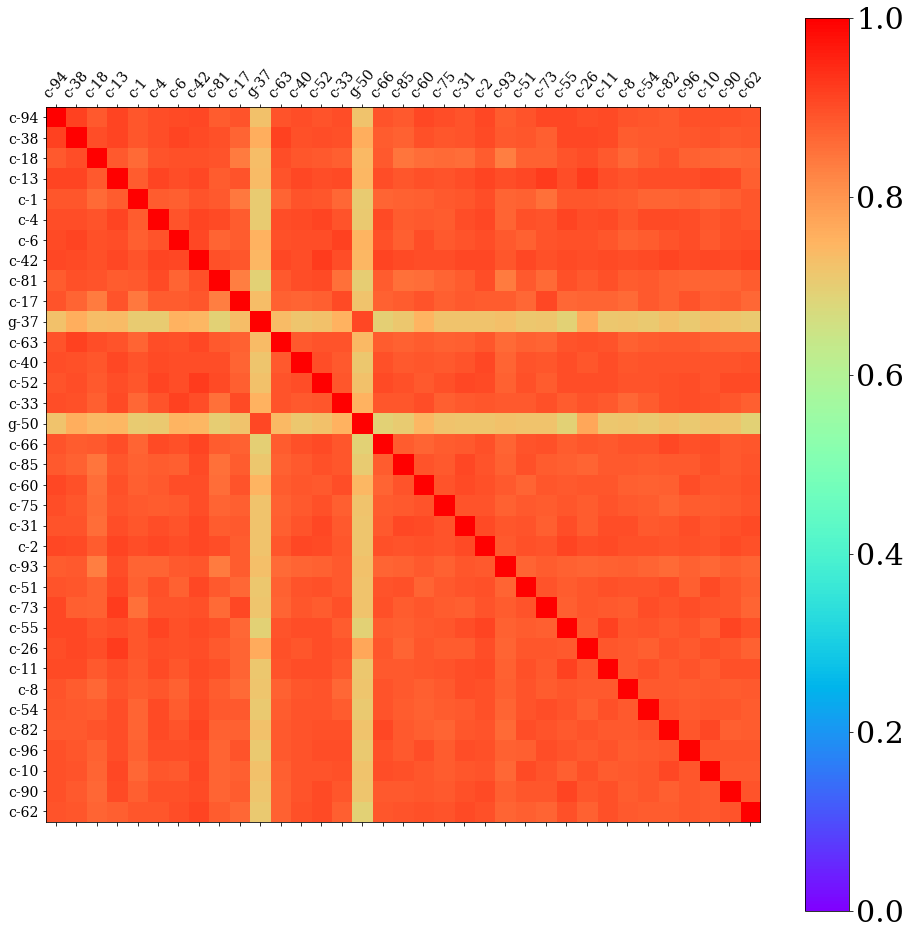

In [ ]:
data = df[all_columns]
plt.rc('font', family='serif')

f = plt.figure(figsize=(16, 16))
cmap_colors = plt.cm.rainbow

plt.matshow(
    data.corr(), 
    fignum=f.number,
    cmap=cmap_colors,
)
plt.clim(0, 1)

plt.xticks(
    range(data.shape[1]), 
    data.columns, 
    fontsize=14, 
    rotation=50
)

plt.yticks(
    range(data.shape[1]), 
    data.columns, 
    fontsize=14
)

cb = plt.colorbar()
cb.ax.tick_params(
    labelsize=30
)
plt.savefig(data_path + 'correlation.png', dpi=300)